<a href="https://colab.research.google.com/github/mananuppadhyay/ResYOLO/blob/main/ResYolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
dataset_url= 'https://www.kaggle.com/datasets/sshikamaru/car-object-detection'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mananuppadhyay
Your Kaggle Key: ··········


100%|██████████| 112M/112M [00:04<00:00, 26.7MB/s]


In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [4]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches
import random
import cv2
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
root = '/content/car-object-detection/data/training_images/'

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

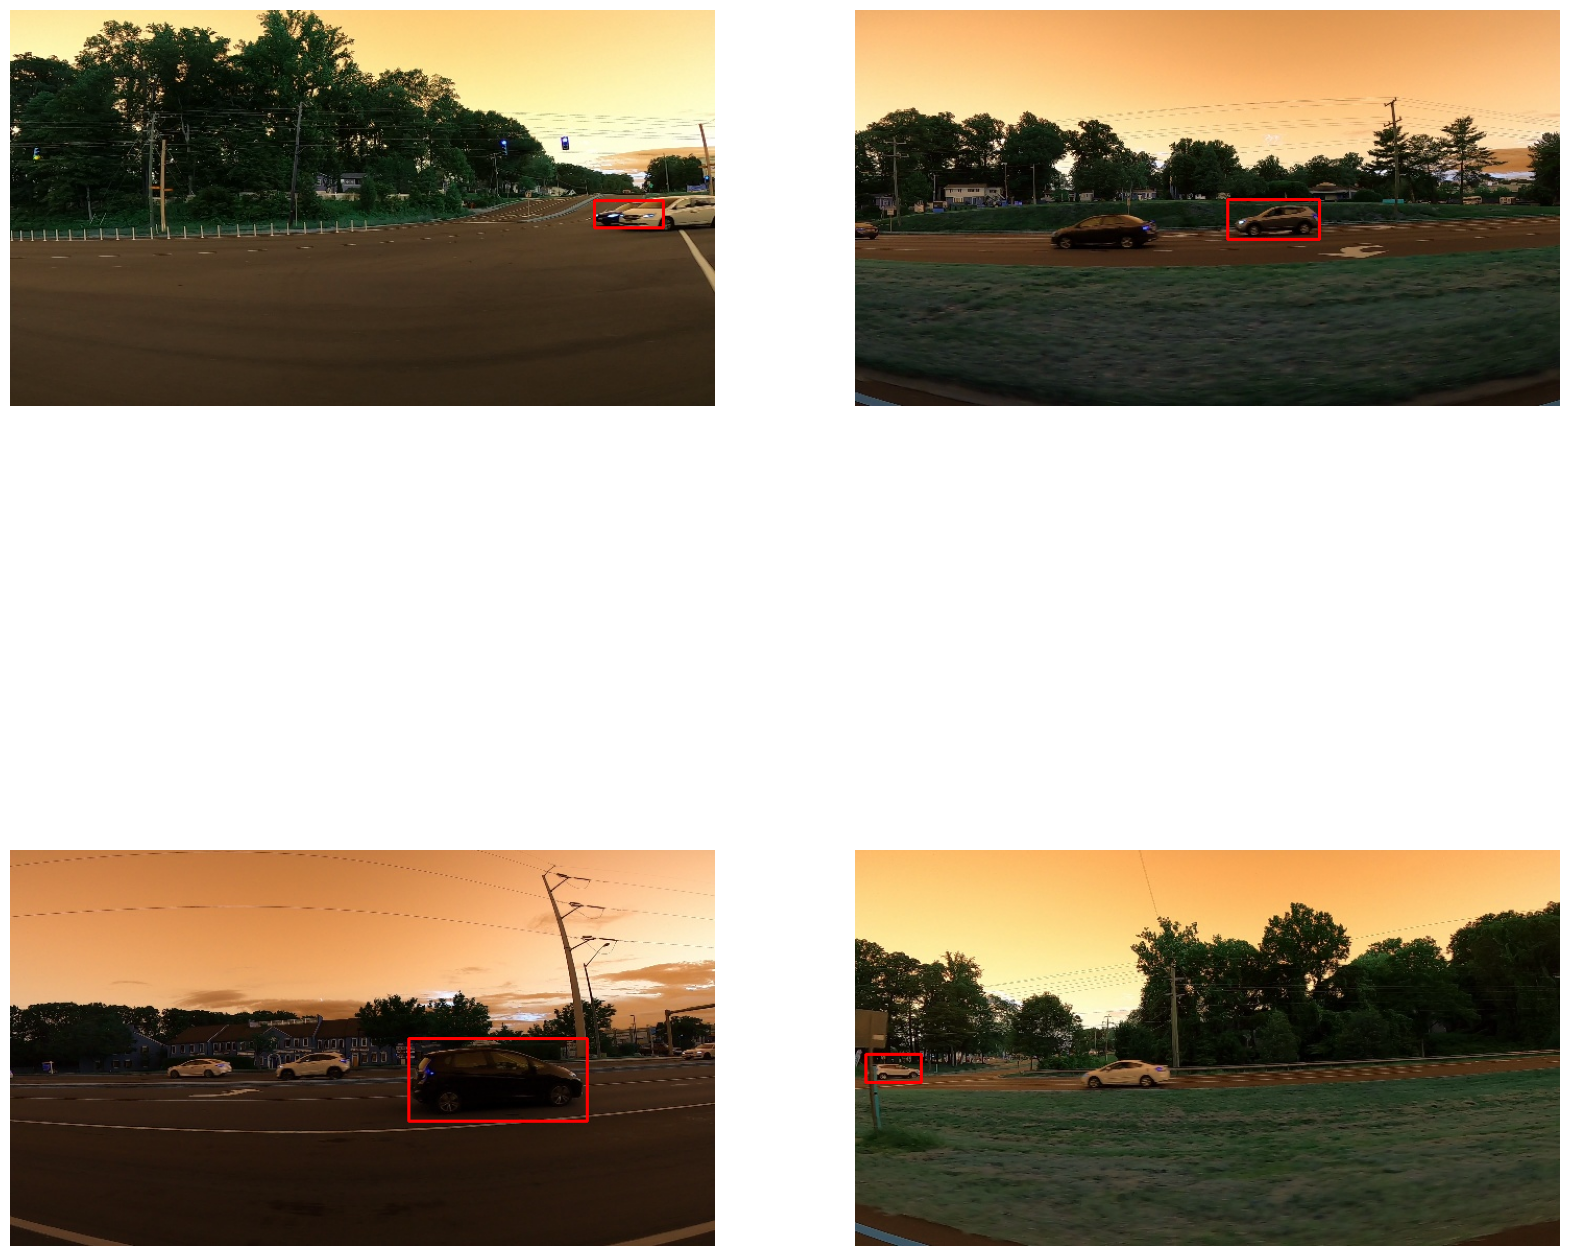

In [6]:
train_df = pd.read_csv('/content/car-object-detection/data/train_solution_bounding_boxes (1).csv')
fig = plt.figure(figsize=(20,20))
random_list = random.sample(range(0, train_df.shape[0]), 4)

for i, idx in enumerate(random_list):
    x1, x2, y1, y2 = train_df.iloc[idx,:]['xmin'], train_df.iloc[idx,:]['xmax'], train_df.iloc[idx,:]['ymin'], train_df.iloc[idx,:]['ymax']

    image_path = cv2.imread(glob.glob(root + train_df.iloc[idx,:]['image'])[0])
    cv2.rectangle(image_path, (int(x1), int(y1)), (int(x2), int(y2)),(255, 0, 0), 2)

    fig.add_subplot(2, 2, i+1)
    plt.imshow(image_path)
    plt.axis('off');

In [7]:
scaler = MinMaxScaler()
train_df[['xmin', 'ymin', 'xmax', 'ymax']] = scaler.fit_transform(train_df[['xmin', 'ymin', 'xmax', 'ymax']])
train_df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,0.435936,0.647541,0.462081,0.226398
1,vid_4_10000.jpg,0.023503,0.647541,0.141748,0.346439
2,vid_4_10040.jpg,0.370735,0.475410,0.514966,0.346439
3,vid_4_10020.jpg,0.769522,0.401639,0.928983,0.301979
4,vid_4_10060.jpg,0.025777,0.639344,0.160635,0.364223
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,0.836707,0.031939,0.344559
555,vid_4_9880.jpg,0.511290,0.135473,0.784791,0.474327
556,vid_4_9900.jpg,0.000000,0.333469,0.174905,0.371407
557,vid_4_9960.jpg,0.755489,0.399467,0.908745,0.277437


In [8]:
height, width = 448, 448

# Create training transform with TrivialAugment
train_transform_trivial_augment = tt.Compose([

    tt.Resize((height, width)),
    tt.TrivialAugmentWide(num_magnitude_bins=31),
    tt.ToTensor(),
    tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create testing transform (no data augmentation)
test_transform = tt.Compose([
    tt.Resize((height, width)),
    tt.ToTensor(),
    tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
class VehicleDetection(Dataset):
    def __init__(self, dataframe, transform):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        x1, x2, y1, y2 = self.df.iloc[idx,:]['xmin'], self.df.iloc[idx,:]['xmax'], self.df.iloc[idx,:]['ymin'], self.df.iloc[idx,:]['ymax']

        image_list = glob.glob(root + self.df.iloc[idx,:]['image'])[0]

        if type(image_list) == str:
            image_list = [image_list]

        x1 = torch.tensor(x1, dtype=torch.float)
        x2 = torch.tensor(x2, dtype=torch.float)
        y1 = torch.tensor(y1, dtype=torch.float)
        y2 = torch.tensor(y2, dtype=torch.float)

        for image in image_list:
            img = Image.open(image)

        return self.transform(img), torch.tensor([x1, y1, x2, y2])

In [10]:
train_data_custom = VehicleDetection(train_df.iloc[:512, :], train_transform_trivial_augment)
test_data_custom = VehicleDetection(train_df.iloc[-32:, :], test_transform)

In [11]:
print(f"We have {len(train_data_custom)} training datapoints and {len(test_data_custom)} testing datapoints")

We have 512 training datapoints and 32 testing datapoints


In [12]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=32,
                                    num_workers=2,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7bb1f09a3f70>,
 <torch.utils.data.dataloader.DataLoader at 0x7bb1f09a06d0>)

In [13]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 448, 448]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32, 4])


In [14]:
import torchvision
from torchvision.models import resnet50

In [15]:
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.resnet50(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 253MB/s]


In [16]:
!pip install torchinfo

In [17]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


In [18]:
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

# Remove the last layers (AdaptiveAvgPool2d and Linear)
modules = list(resnet.children())[:-2]
resnet_feature_extractor = nn.Sequential(*modules)


for param in resnet_feature_extractor.parameters():
    param.requires_grad = False

# Define your custom network
custom_network = nn.Sequential(
    nn.Conv2d(2048, 1024, kernel_size=3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),
    nn.Conv2d(1024, 1024, kernel_size=1),
    nn.BatchNorm2d(1024),
    nn.ReLU(),
    nn.Conv2d(1024, 4, kernel_size=3),  # Adjust to have 4 output channels
    nn.AdaptiveAvgPool2d(1)  # Add an adaptive average pooling layer to make output spatial resolution 1x1
    )

# Combine the ResNet feature extractor and the custom network
class ModifiedModel(nn.Module):
    def __init__(self):
        super(ModifiedModel, self).__init__()
        self.resnet_feature_extractor = resnet_feature_extractor
        self.custom_network = custom_network

    def forward(self, x):
        features = self.resnet_feature_extractor(x)
        output = self.custom_network(features)
        return output

# Create an instance of the modified model
model = ModifiedModel()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


In [19]:
import torchinfo
torchinfo.summary(model=model,
        input_size=(32, 3, 448, 448), # make sure this is "input_size", not "input_shape"
       # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ModifiedModel (ModifiedModel)                 [32, 3, 448, 448]    [32, 4, 1, 1]        --                   Partial
├─Sequential (resnet_feature_extractor)       [32, 3, 448, 448]    [32, 2048, 14, 14]   --                   False
│    └─Conv2d (0)                             [32, 3, 448, 448]    [32, 64, 224, 224]   (9,408)              False
│    └─BatchNorm2d (1)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (128)                False
│    └─ReLU (2)                               [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Sequential (4)                         [32, 64, 112, 112]   [32, 256, 112, 112]  --                   False
│    │    └─Bottleneck (0)                    [32, 64, 112, 112]   [32, 256, 112

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models



# Initialize the model, loss function, and optimizer
model = ModifiedModel()  # Modify with your specific parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Define your data loaders for training and testing
# train_dataloader_custom and test_dataloader_custom should be set up previously

# Training loop parameters
epochs = 5

train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader_custom):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.view(outputs.size(0), -1)

        print(outputs.shape)
        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        train_loss_arr.append(loss)
        if batch_idx % 10 == 9:  # Print every 10 batches
            print(f"[Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_dataloader_custom)}] Loss: {running_loss/10:.4f}")
            running_loss = 0.0

# Optional: Save the trained model
torch.save(model.state_dict(), "trained_model.pth")


torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
[Epoch 1, Batch 10/16] Loss: 0.1134
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
[Epoch 2, Batch 10/16] Loss: 0.0734
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([32, 4])
[Epoch 3, Batch 10/16] Loss: 0.0700
torch.Size([32, 4])
torch.Size([32, 4])
torch.Size([

In [21]:
model.eval()
with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader_custom):

        X = X.to(device)
        y = y.to(device)

        # Forward
        test_pred = model(X)

print(test_pred.shape)

torch.Size([32, 4, 1, 1])


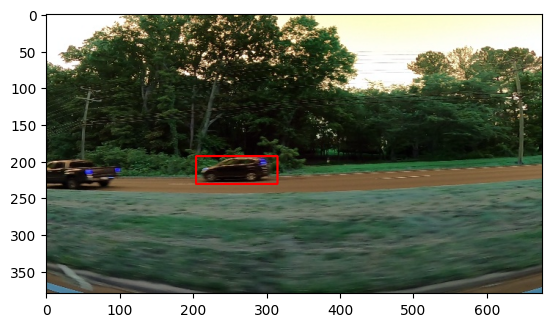

In [22]:
idx = 20

test_pred= test_pred.view(32, 4)
test_pred_0 = test_pred[idx]
y_0 = y[idx]
X_0 = X[idx]

actual_corr = scaler.inverse_transform([y_0.cpu().numpy()])
predicted_corr = scaler.inverse_transform([test_pred_0.cpu().numpy()])

image_path = cv2.imread(glob.glob(root + train_df.iloc[-32+idx,:]['image'])[0])
corr = actual_corr
cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])),(255, 0, 0), 2)
plt.imshow(image_path)

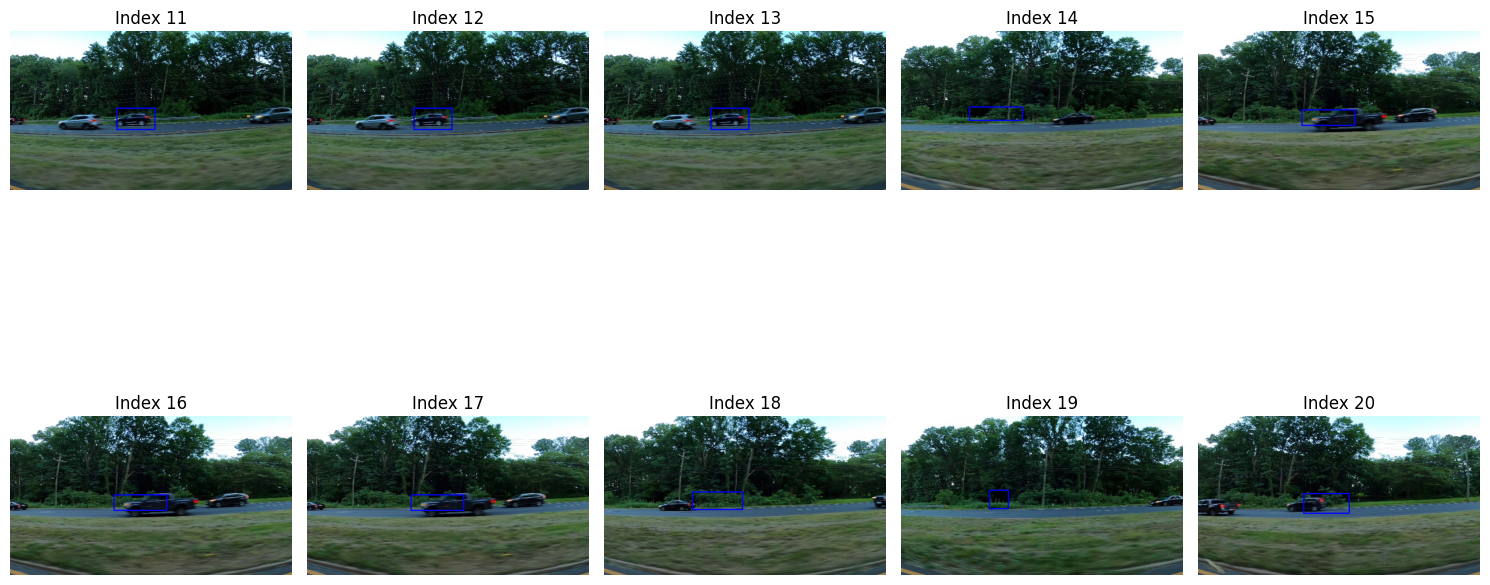

In [23]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_pred' has shape [32, 4] and 'y' and 'X' are the same shape
# Also, 'predicted_corr' and 'train_df' should be defined appropriately

# Create a subplot grid for displaying multiple images
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for idx in range(11, 21):
    row = (idx - 11) // num_cols
    col = (idx - 11) % num_cols

    test_pred_0 = test_pred[idx]
    y_0 = y[idx]
    X_0 = X[idx]

    actual_corr = scaler.inverse_transform([y_0.cpu().numpy()])
    predicted_corr = scaler.inverse_transform([test_pred_0.cpu().numpy()])

    image_path = cv2.imread(glob.glob(root + train_df.iloc[-32 + idx, :]['image'])[0])

    corr = predicted_corr
    cv2.rectangle(image_path, (int(corr[0][0]), int(corr[0][1])), (int(corr[0][2]), int(corr[0][3])), (255, 0, 0), 2)

    axes[row, col].imshow(cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f'Index {idx}')
    axes[row, col].axis('off')


plt.tight_layout()
plt.show()
